# Notebook for social neural population decoding (NPD)
With inspiration from:
"The geometry of hippocampal CA2 representations enables abstract coding of social familiarity and identity" - Boyle 2022

**Note!** The analysis needs to be repeated for *each animal separately*, and only persistent units across all selected actions will be included in the analysis. This because the input to an SVM is interpreted as a vector of unique units. Hence units from an animal B can not replace the input of an SVM trained on units from animal A. Lastly, this notebook trains SVMs to predict social interactions. Other notebooks try to decode trial and space.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('../bioAI.mplstyle')
import expipe
import sys
import pathlib
import numpy as np
import numpy.ma as ma
import scipy
import tqdm
import pandas as pd

sys.path.append('../ca2-mec') if '../ca2-mec' not in sys.path else None 
import dataloader as dl
from utils import *
from plotting_functions import *
from methods import *

In [3]:
project = expipe.get_project(dl.project_path())
project.actions

In [4]:
lim = [0,1200] # limit recording times - in seconds
include_actions = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6'] # choose actions to include
#include_actions = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']

# Cast assertion error if include_actions contain actions from multiple entities. 
animal_entity = include_actions[0].split('-')[0]
multiple_entities = all([animal_entity in action_id for action_id in include_actions])
assert multiple_entities, "Requires only actions from same animal entity! Read start of notebook!"

spikes = []
tracking = {}
for action_id in include_actions:
    spikes += dl.load_spiketrains(action_id, lim=lim, identify_neurons=True)
    tracking[action_id] = dl.load_tracking(action_id, lim=lim, ca2_transform_data=True) # only get positions
    
print("load #spikes: ", len(spikes))
    
# correct for inconsistent mua-annotations
spikes = dl.correct_mua(spikes, only_good_mua=True)
print("#units after mua-corrections:", len(spikes))
spatial_map = sp.SpatialMap()

# SELECT brain region(s) to include cells from
spikes = dl.in_brain_regions(spikes, ['ca2'])
print("#units after brain region selection:", len(spikes))

# only include cells that are persistent across all actions
spikes = dl.persistent_units(spikes, include_actions)
npersistent = int(len(spikes) / len(include_actions))
print(f"Num spike_trains: {len(spikes)}. Num persistent units: {npersistent}")

load #spikes:  124
#units after mua-corrections: 121
#units after brain region selection: 121
Num spike_trains: 70. Num persistent units: 14


### Setup input data and labels
This should follow the format:
- X.shape = (samples, num_features) -> neural rate activity
- y.shape = (samples) -> scalars indicating labelled class

In [5]:
# sort spikes on unit_idnum and action_id, respectively
spikes.sort(key=lambda spike_train: spike_train.annotations['unit_idnum'])
spikes.sort(key=lambda spike_train: spike_train.annotations['action_id'])
unit_idnums = np.unique([spike_train.annotations["unit_idnum"] for spike_train in spikes])

# print the spike properties that the spikes list has been sorted on to confirm sorting
#[(spike_train.annotations["action_id"], spike_train.annotations["unit_idnum"]) for spike_train in spikes]

In [6]:
categories_to_include = [0, 1] # <--- SELECT categories to include
window_size=0.5 # boyle2022 used 100ms

#X,y_true = Xy_social(spikes,tracking,categories_to_include,input_dim=npersistent,window_size=window_size,res=10)
X,y_true = Xy_spatial(spikes,tracking,categories_to_include,input_dim=npersistent,window_size=window_size,res=10)
#X,y_true = Xy_trial(spikes,tracking,categories_to_include,input_dim=npersistent,window_size=window_size,res=10)

100%|██████████| 2398/2398 [00:00<00:00, 11347.11it/s]


In [7]:
# show the range of rates an input can take, and how often these appear.
# first row: number of spikes within time window
# second row: number of occurences a unit has this many spikes
np.unique(X, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35.]),
 array([36897,  3594,  1964,  1618,  1438,  1163,  1015,   809,   632,
          587,   469,   357,   276,   232,   192,   157,   137,   112,
           65,    51,    41,    24,    31,    20,    11,    18,     9,
            8,     9,     4,     6,     2,     2,     2,     1,     1]))

### Show firing rate distributions (histogram) for each neuron in different categories
We look at these plots to get an intuition for whether there the data distributions seem to be different from each other depending on the (labelled) category of the data. If they are different, we would expect the data to at least be somewhat separable. If the data distributions are not different this does **not** mean the data is not seperable. In this case, however, there would have to be some ordering within the data wrt. the labels that makes the data separable. In the final case, the data may be separable when we have a model with very high complexity - then even random shuffeling of the data labels could be separable by such models.

**NOTE!** Changing the parameter "density" between "True" and "False" gives two different intutions:
1. True -> Gives a feeling for the similarity in distributions between the two categories
2. False -> Gives a feeling HOW MUCH DATA are within each category.

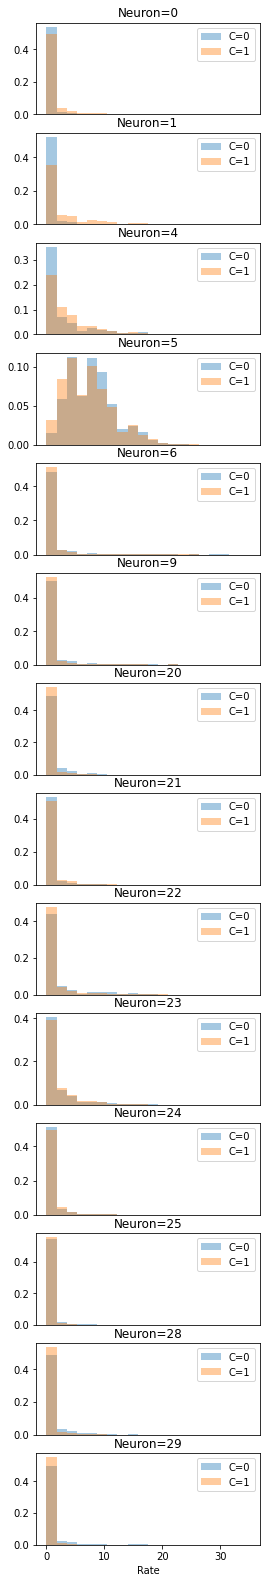

In [8]:
nfeatures = X.shape[-1]
ncategories = len(categories_to_include)
fig,axs = plt.subplots(nrows=nfeatures,figsize=(4,nfeatures*2))
nbins=20
bins = np.linspace(np.min(X), np.max(X), nbins+1)
for j, category in enumerate(categories_to_include):
    [axs[i].hist(X[:,i][y_true == category],bins=bins,alpha=0.4,label=f"C={category}",density=True) for i in range(nfeatures)]
[axs[i].set_title(f"Neuron={unit_idnums[i]}") for i in range(nfeatures)]
[axs[i].legend() for i in range(nfeatures)];
[axs[i].set_xticks([]) for i in range(nfeatures-1)]
axs[-1].set_xlabel("Rate");

## MACHINE LEARNING

In [9]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score

test_size=0.25 # boyle2022 used 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=test_size, random_state=0)
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(class_weight='balanced', kernel='linear'))])

### Look at predictions and label histograms in training and test sets
This gives an intuition for two things:
1. That the training set is representative (looks the same) of the test set in terms of the labels
2. (i) That the classifier (model) predicts events in both categories, and (ii) how it relates to the labelled distributions

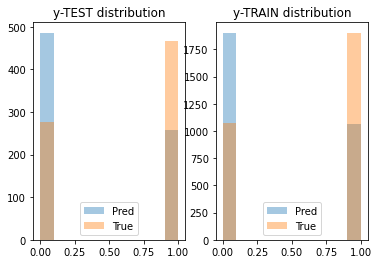

In [10]:
fig,axs = plt.subplots(ncols=2)

y_hat_test = clf.predict(X_test)
axs[0].hist(y_hat_test, alpha=0.4,label="Pred")
axs[0].hist(y_test, alpha=0.4, label="True")
axs[0].set_title("y-TEST distribution")
axs[0].legend()

y_hat_train = clf.predict(X_train)
axs[1].hist(y_hat_train, alpha=0.4, label="Pred")
axs[1].hist(y_train, alpha=0.4, label="True")
axs[1].set_title("y-TRAIN distribution")
axs[1].legend()

### Confusion matrix
Gives an overview of the distribution of prediction-label categories: True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN). Note that this is for the binary classification setting. If the classes are labelled e.g. 1 and 2, then: TP = (1,1), TN = (2,2), FP = (1,2), and FN = (2,1), if we consider 1s as "positives" and 2s as "negatives". In the ideal case, the classifier (model) would correctly classify all instances (both positives and negatives), which would result in only events (100%) in the TP = (1,1) and TN = (2,2) cases. In "the worst" scenario, the classifier only predicts one label for all inputs (clever but boring and lazy classifier that only picks the "most likely" class, regardless of what input it gets). This can be seen in the confusion matrix by assigning all predictions to either the positive (1) or negative (2) classes. In other words, assuming the classifier always predicts positives (1), then TP + FP = 1, and TN + FN = 0.

Categories: [0. 1.]. Probability of category: [0.36297494 0.63702506]

 SVM score: Accuracy  0.608
F1-score  0.619


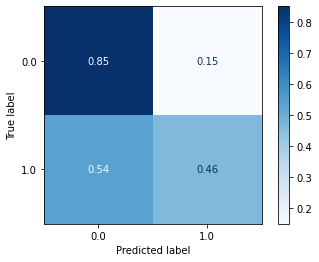

In [11]:
categories, counts = np.unique(y_true, return_counts=True)
print(f"Categories: {categories}.", "Probability of category:", counts/np.sum(counts))
print("\n SVM score: Accuracy ", round(clf.score(X_test,y_test),3))
if len(categories) == 2:
    print("F1-score ", round(f1_score(y_test, clf.predict(X_test),pos_label=categories[0]),3))
_ = plot_confusion_matrix(clf, X_test, y_test, normalize='true', cmap=plt.cm.Blues)

### Relative Neuron Importance
Rank the importance a neuron has on the classification task. Here, we consider "importance" to be synonomous with SVM linear layer weight magnitudes. Geometrically this amounts to "how orthogonal (or conversely, paralell)" the SVM decision boundary is to the basis vector inferred by a neuron. Note that this measure is relative, so it just means how important is a neuron RELATIVE to the other neurons in making the decision. The importance measure will always sum to 1 over all the neurons/features of the classifier. In other words, if all neurons are (equally) redundant, or if all neurons are (equally) important for the classification, both cases leads to the same relative importance measure.

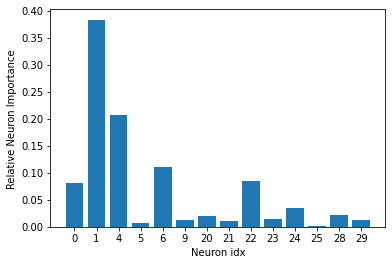

In [12]:
plt.bar(np.arange(nfeatures),relative_feature_importance(clf['svc'].coef_[0]))
plt.ylabel("Relative Neuron Importance")
plt.xlabel("Neuron idx")
plt.xticks(range(nfeatures),labels=unit_idnums);

### Distance to decision boundary
Plot the distribution of distances to the decision boundary. This shows how "robustly" different samples have been classified. The further a datapoint is from the decison boundary, the "more certain" the classifier is in its decision.

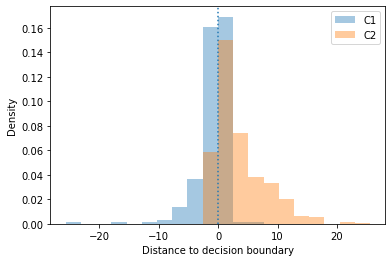

In [13]:
dists = distance_to_boundary(X_test,clf['svc'],y_test)
nbins=20
bins = np.linspace(np.min(dists),np.max(dists),nbins+1)
dists_c1 = dists[y_test == categories_to_include[0]]
dists_c2 = dists[y_test == categories_to_include[1]]
plt.hist(dists_c1,bins,density=True,alpha=0.4,label='C1')
plt.hist(dists_c2,bins,density=True,alpha=0.4,label='C2')
plt.axvline(0,ls=':')
plt.xlabel('Distance to decision boundary')
plt.ylabel('Density')
plt.legend();

### Plot ratemaps of units involved in SVM-analysis

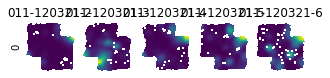

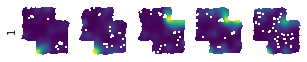

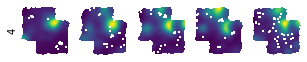

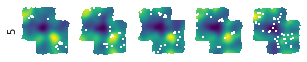

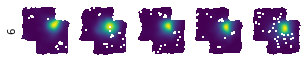

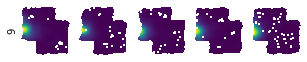

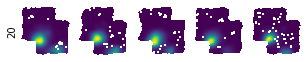

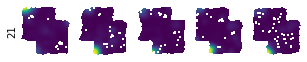

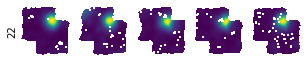

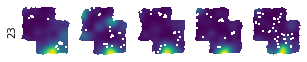

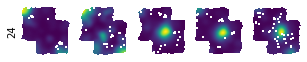

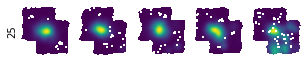

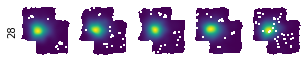

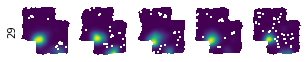

In [14]:
# sort on unit id
figscale = 1
from plotting_functions import axis_off_labels_on

add_title = True
spatial_map = sp.SpatialMap()
for unit_idnum in unit_idnums:
    unit_spikes = [spike_train for spike_train in spikes if spike_train.annotations["unit_idnum"] == unit_idnum]
    fig,axs = plt.subplots(ncols=len(unit_spikes),figsize=(len(unit_spikes)*figscale, 1*figscale))
    
    for ax, spike_train in zip(axs, unit_spikes):
        x,y,t,_ = tracking[spike_train.annotations["action_id"]].T
        ratemap = spatial_map.rate_map(x, y, t, spike_train)
        ax.imshow(ratemap.T,origin='lower')
        axis_off_labels_on(ax)
        
        # add action_id title to first few plots
        if add_title:
            ax.set_title(spike_train.annotations["action_id"])
    add_title = False
    
    axs[0].set_ylabel(spike_train.annotations["unit_idnum"])